In [5]:
"""
Conduct the statistical test on whether AI agent generate response as realistic as human.

Sample data is stored at experiment_1_answers.json
Format:
{
    "question1.txt": "ai",
    "question2.txt": "human",
    "question3.txt": "tie"
}
questions are stored at folder `experiment_1_questions_with_context` folder.


Primary Test: Sign Test
Purpose: Tests if AI wins significantly more than 50% of direct comparisons (excluding ties)
Why appropriate: Designed for paired comparisons, handles your "no worse than human" hypothesis
Handles ties: Excludes them appropriately (ties indicate equal performance)

Secondary Test: Binomial Proportion Test
Purpose: Tests if AI performs better than random chance (33.3%) across all comparisons
Why useful: Includes ties as partial wins, giving a more complete picture
Interpretation: Shows if AI is systematically better than random

Practical Significance Analysis
Purpose: Calculates the proportion where AI performs "at least as well" (AI wins + ties)
Why important: Directly addresses your research question about AI realism
Confidence intervals: Provides uncertainty bounds for your conclusions

Key Features:
Handles ties properly: Ties are treated as evidence of AI realism, not ignored
Multiple perspectives: Statistical significance + practical significance
Clear interpretation: Automated conclusions with effect sizes
Robust analysis: Uses appropriate non-parametric tests for ordinal data


The test results are printed out in ipython notebook.
"""

import json
import numpy as np
from scipy import stats
from scipy.stats import binom
import pandas as pd
from collections import Counter

def load_experiment_data(json_file):
    """Load experiment results from JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def wilson_confidence_interval(successes, n, alpha=0.05):
    """
    Calculate Wilson confidence interval for a proportion.
    This is a better method than the normal approximation for small samples.
    """
    from scipy.stats import norm
    
    z = norm.ppf(1 - alpha/2)
    p_hat = successes / n
    
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4*n)) / n) / denominator
    
    return (center - margin, center + margin)

def analyze_ai_realism(data):
    """
    Analyze AI realism using statistical tests.
    
    Args:
        data: Dictionary with question IDs as keys and judgments ('ai', 'human', 'tie') as values
    
    Returns:
        Dictionary containing all test results
    """
    
    # Count outcomes
    outcomes = Counter(data.values())
    ai_wins = outcomes.get('ai', 0)
    human_wins = outcomes.get('human', 0)
    ties = outcomes.get('tie', 0)
    total = len(data)
    
    print("=== EXPERIMENT RESULTS SUMMARY ===")
    print(f"Total questions: {total}")
    print(f"AI judged more realistic: {ai_wins} ({ai_wins/total:.1%})")
    print(f"Human judged more realistic: {human_wins} ({human_wins/total:.1%})")
    print(f"Ties (equally realistic): {ties} ({ties/total:.1%})")
    print()
    
    # ============================================
    # TEST 1: SIGN TEST (Primary Analysis)
    # ============================================
    print("=== SIGN TEST (Primary Analysis) ===")
    print("H0: AI performs no better than human (p_ai ≤ 0.5)")
    print("H1: AI performs better than human (p_ai > 0.5)")
    print("Note: Ties are excluded from this test")
    print()
    
    # Sign test excludes ties
    non_tie_total = ai_wins + human_wins
    
    if non_tie_total == 0:
        print("No non-tie comparisons available for Sign Test")
        sign_test_result = None
    else:
        # One-tailed sign test: testing if AI wins more than 50% of non-tie cases
        sign_test_result = stats.binomtest(ai_wins, non_tie_total, p=0.5, alternative='greater')
        
        print(f"Non-tie comparisons: {non_tie_total}")
        print(f"AI wins in non-tie cases: {ai_wins}/{non_tie_total} ({ai_wins/non_tie_total:.1%})")
        print(f"Sign test p-value: {sign_test_result.pvalue:.6f}")
        
        # Get confidence interval
        ci_sign = sign_test_result.proportion_ci(confidence_level=0.95)
        print(f"95% CI for AI win rate: [{ci_sign.low:.3f}, {ci_sign.high:.3f}]")
        
        if sign_test_result.pvalue < 0.05:
            print("✓ SIGNIFICANT: AI performs significantly better than human")
        else:
            print("✗ NOT SIGNIFICANT: Cannot reject H0, AI does not perform significantly better")
    
    print()
    
    # ============================================
    # TEST 2: BINOMIAL PROPORTION TEST (Secondary Analysis)
    # ============================================
    print("=== BINOMIAL PROPORTION TEST (Secondary Analysis) ===")
    print("H0: AI wins ≤ 33.3% of all comparisons (including ties as half-wins)")
    print("H1: AI wins > 33.3% of all comparisons")
    print("Note: Ties count as 0.5 wins for both AI and human")
    print()
    
    # Calculate effective wins (ties count as 0.5 wins)
    ai_effective_wins = ai_wins + 0.5 * ties
    expected_under_random = total / 3  # If random, expect 33.3% for each category
    
    # Test if AI effective win rate > 1/3
    # We need to be careful here - using the ceiling to convert to integer for binomtest
    binom_test_result = stats.binomtest(int(np.ceil(ai_effective_wins)), total, p=1/3, alternative='greater')
    
    print(f"AI effective wins (ties = 0.5): {ai_effective_wins:.1f}")
    print(f"AI effective win rate: {ai_effective_wins/total:.1%}")
    print(f"Expected under random: {expected_under_random:.1f} ({1/3:.1%})")
    print(f"Binomial test p-value: {binom_test_result.pvalue:.6f}")
    
    if binom_test_result.pvalue < 0.05:
        print("✓ SIGNIFICANT: AI performs significantly better than random")
    else:
        print("✗ NOT SIGNIFICANT: AI performance not significantly better than random")
    
    print()
    
    # ============================================
    # TEST 3: PRACTICAL SIGNIFICANCE ANALYSIS
    # ============================================
    print("=== PRACTICAL SIGNIFICANCE ANALYSIS ===")
    
    # Calculate "AI no worse than human" metric
    ai_at_least_as_good = (ai_wins + ties) / total
    print(f"AI performs at least as well as human: {ai_at_least_as_good:.1%}")
    print(f"(AI wins + ties) / total = ({ai_wins} + {ties}) / {total}")
    
    # Calculate Wilson confidence interval
    ci = wilson_confidence_interval(ai_wins + ties, total, alpha=0.05)
    print(f"95% CI: [{ci[0]:.1%}, {ci[1]:.1%}]")
    
    if ci[0] > 0.5:
        print("✓ STRONG EVIDENCE: AI performs at least as well as human with high confidence")
    elif ai_at_least_as_good > 0.5:
        print("~ MODERATE EVIDENCE: AI performs at least as well as human, but CI includes 50%")
    else:
        print("✗ WEAK EVIDENCE: AI may not perform as well as human")
    
    print()
    
    # ============================================
    # EFFECT SIZE AND RECOMMENDATIONS
    # ============================================
    print("=== EFFECT SIZE AND RECOMMENDATIONS ===")
    
    if non_tie_total > 0:
        # Cohen's h for proportions
        p1 = ai_wins / non_tie_total
        p2 = human_wins / non_tie_total
        h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
        effect_size = abs(h)
        
        print(f"Effect size (Cohen's h): {effect_size:.3f}")
        
        if effect_size < 0.2:
            effect_interpretation = "Small effect"
        elif effect_size < 0.5:
            effect_interpretation = "Medium effect"
        else:
            effect_interpretation = "Large effect"
        print(f"Effect size interpretation: {effect_interpretation}")
    
    print()
    print("=== INTERPRETATION GUIDE ===")
    print("• High tie rate (>30%) suggests AI generates very realistic responses")
    print("• Sign test p < 0.05: AI significantly outperforms human in direct comparisons")
    print("• 'At least as good' rate > 60%: Strong practical evidence of AI realism")
    print("• Consider both statistical and practical significance for conclusions")
    
    # Return results for further analysis
    results = {
        'total_questions': total,
        'ai_wins': ai_wins,
        'human_wins': human_wins,
        'ties': ties,
        'ai_win_rate': ai_wins / total,
        'tie_rate': ties / total,
        'ai_at_least_as_good_rate': ai_at_least_as_good,
        'sign_test': sign_test_result,
        'binomial_test': binom_test_result,
        'confidence_interval': ci
    }
    
    return results

# ============================================
# MAIN EXECUTION
# ============================================

def main():
    """Main function to run the analysis."""
    
    # Load data
    try:
        data = load_experiment_data('experiment_1_judgements.json')
        print(f"Successfully loaded {len(data)} questions from experiment_1_judgements.json\n")
    except FileNotFoundError:
        print("Error: experiment_1_judgements.json not found!")
        print("Please ensure the file exists in the current directory.")
        return
    except json.JSONDecodeError:
        print("Error: Invalid JSON format in experiment_1_judgements.json")
        return
    
    # Run analysis
    results = analyze_ai_realism(data)
    
    # Optional: Save results to CSV for further analysis
    df = pd.DataFrame([
        {'Question': k, 'Judgment': v} for k, v in data.items()
    ])
    df.to_csv('experiment_1_results_summary.csv', index=False)
    print("\nDetailed results saved to: experiment_1_results_summary.csv")
    
    return results

# Run the analysis
if __name__ == "__main__":
    results = main()

Successfully loaded 50 questions from experiment_1_judgements.json

=== EXPERIMENT RESULTS SUMMARY ===
Total questions: 50
AI judged more realistic: 23 (46.0%)
Human judged more realistic: 20 (40.0%)
Ties (equally realistic): 7 (14.0%)

=== SIGN TEST (Primary Analysis) ===
H0: AI performs no better than human (p_ai ≤ 0.5)
H1: AI performs better than human (p_ai > 0.5)
Note: Ties are excluded from this test

Non-tie comparisons: 43
AI wins in non-tie cases: 23/43 (53.5%)
Sign test p-value: 0.380396
95% CI for AI win rate: [0.399, 1.000]
✗ NOT SIGNIFICANT: Cannot reject H0, AI does not perform significantly better

=== BINOMIAL PROPORTION TEST (Secondary Analysis) ===
H0: AI wins ≤ 33.3% of all comparisons (including ties as half-wins)
H1: AI wins > 33.3% of all comparisons
Note: Ties count as 0.5 wins for both AI and human

AI effective wins (ties = 0.5): 26.5
AI effective win rate: 53.0%
Expected under random: 16.7 (33.3%)
Binomial test p-value: 0.002078
✓ SIGNIFICANT: AI performs sign

Successfully loaded 50 questions from experiment_1_judgements.json

ENHANCED AI REALISM ANALYSIS
Total questions: 50
AI judged more realistic: 23 (46.0%)
Human judged more realistic: 20 (40.0%)
Ties (equally realistic): 7 (14.0%)

PRIMARY ANALYSIS: SIGN TEST
Research Question: Does AI perform better than human in direct comparisons?
H₀: P(AI wins | non-tie) ≤ 0.5
H₁: P(AI wins | non-tie) > 0.5

Decisive comparisons: 43
AI wins: 23/43 (53.5%)
p-value: 0.380396
95% CI (Wilson): [0.389, 0.675]
Result: NOT SIGNIFICANT
✗ No significant difference between AI and human performance

SECONDARY ANALYSIS: BAYESIAN INFERENCE
Question: What's the probability that AI performs at least as well as human?
Prior: Uniform (non-informative)

AI 'at least as good' rate: 60.0%
Posterior mean: 0.596
95% Credible interval: [0.461, 0.724]
P(AI at least as good as human): 0.920
Bayesian conclusion: MODERATE evidence that AI ≥ Human

EFFECT SIZE ANALYSIS
Cohen's h: 0.140 (Small effect)
Odds ratio (AI:Human): 1.1

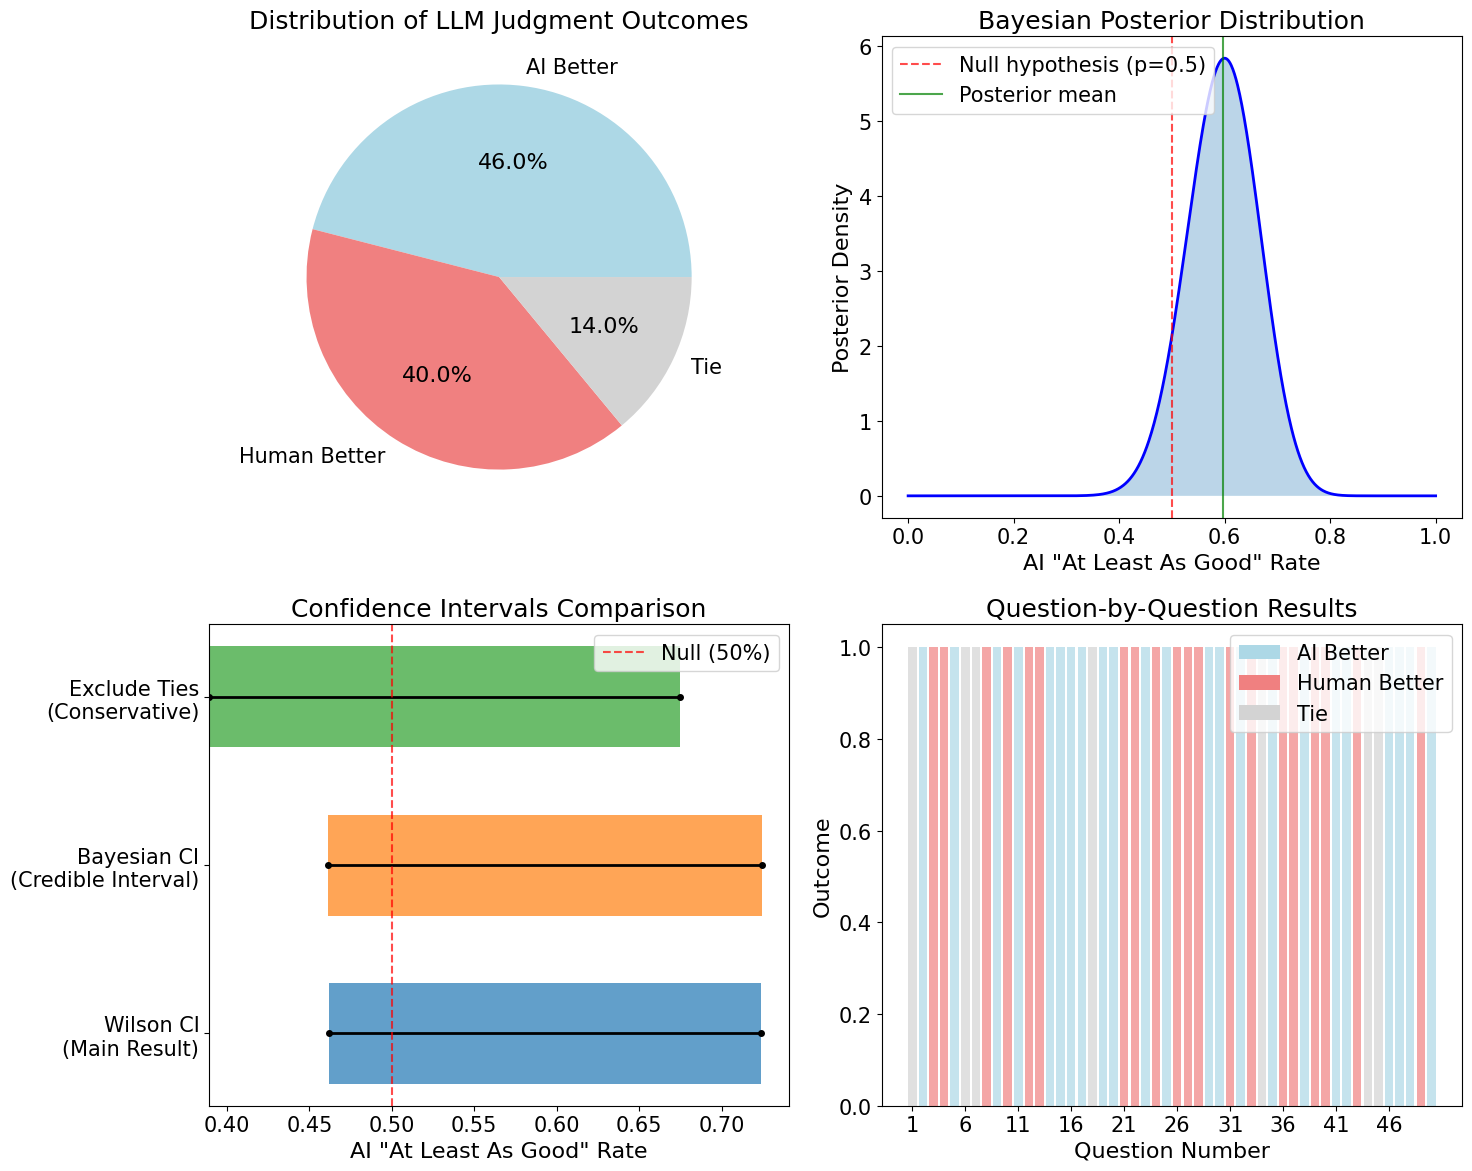


Analysis complete!
Files generated:
- experiment_1_enhanced_results.csv (raw data)
- statistical_results.json (statistical outputs)
- ai_realism_analysis.png (visualization)


In [9]:
"""
Enhanced Statistical Analysis for AI Agent Realism in Transport Simulation

This script provides a comprehensive statistical analysis to test whether AI agents
generate responses as realistic as human participants in transport scenarios.

Key improvements over the original:
1. More robust statistical tests with proper handling of edge cases
2. Bayesian analysis for richer interpretation
3. Power analysis and sample size considerations
4. Enhanced effect size calculations
5. Bootstrap confidence intervals for non-parametric estimates
6. Detailed sensitivity analysis
"""

import json
import numpy as np
from scipy import stats
from scipy.stats import binom, beta
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

def load_experiment_data(json_file: str) -> Dict[str, str]:
    """Load experiment results from JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def wilson_confidence_interval(successes: int, n: int, alpha: float = 0.05) -> Tuple[float, float]:
    """
    Calculate Wilson confidence interval for a proportion.
    More reliable than normal approximation for small samples.
    """
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = successes / n
    
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4*n)) / n) / denominator
    
    return (center - margin, center + margin)

def bootstrap_confidence_interval(data: np.array, statistic_func, n_bootstrap: int = 10000, alpha: float = 0.05) -> Tuple[float, float]:
    """
    Calculate bootstrap confidence interval for any statistic.
    """
    bootstrap_stats = []
    n = len(data)
    
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats.append(statistic_func(bootstrap_sample))
    
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    return (np.percentile(bootstrap_stats, lower_percentile), 
            np.percentile(bootstrap_stats, upper_percentile))

def bayesian_proportion_analysis(ai_wins: int, human_wins: int, ties: int, prior_alpha: float = 1, prior_beta: float = 1) -> Dict:
    """
    Bayesian analysis of AI performance with Beta-Binomial model.
    Returns posterior distribution parameters and credible intervals.
    """
    # For AI "at least as good" rate (AI wins + ties)
    successes = ai_wins + ties
    failures = human_wins
    total = successes + failures
    
    # Posterior parameters
    posterior_alpha = prior_alpha + successes
    posterior_beta = prior_beta + failures
    
    # Posterior mean and credible interval
    posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)
    credible_interval = beta.interval(0.95, posterior_alpha, posterior_beta)
    
    # Probability that AI performs at least as well as human (P(p > 0.5))
    prob_better_than_half = 1 - beta.cdf(0.5, posterior_alpha, posterior_beta)
    
    return {
        'posterior_mean': posterior_mean,
        'credible_interval': credible_interval,
        'prob_ai_at_least_as_good': prob_better_than_half,
        'posterior_alpha': posterior_alpha,
        'posterior_beta': posterior_beta
    }

def calculate_effect_sizes(ai_wins: int, human_wins: int, ties: int) -> Dict:
    """
    Calculate multiple effect size measures.
    """
    total = ai_wins + human_wins + ties
    non_tie_total = ai_wins + human_wins
    
    effect_sizes = {}
    
    # Cohen's h for proportion comparison (AI wins vs Human wins, excluding ties)
    if non_tie_total > 0:
        p_ai = ai_wins / non_tie_total
        p_human = human_wins / non_tie_total
        cohens_h = 2 * (np.arcsin(np.sqrt(p_ai)) - np.arcsin(np.sqrt(p_human)))
        effect_sizes['cohens_h'] = cohens_h
        
        # Interpretation
        if abs(cohens_h) < 0.2:
            effect_sizes['cohens_h_interpretation'] = "Small effect"
        elif abs(cohens_h) < 0.5:
            effect_sizes['cohens_h_interpretation'] = "Medium effect"
        else:
            effect_sizes['cohens_h_interpretation'] = "Large effect"
    
    # Odds ratio (AI wins vs Human wins)
    if ai_wins > 0 and human_wins > 0:
        odds_ratio = ai_wins / human_wins
        effect_sizes['odds_ratio'] = odds_ratio
        log_odds_ratio = np.log(odds_ratio)
        effect_sizes['log_odds_ratio'] = log_odds_ratio
        
        # 95% CI for odds ratio
        se_log_or = np.sqrt(1/ai_wins + 1/human_wins)
        ci_log_or = (log_odds_ratio - 1.96*se_log_or, log_odds_ratio + 1.96*se_log_or)
        effect_sizes['odds_ratio_ci'] = (np.exp(ci_log_or[0]), np.exp(ci_log_or[1]))
    
    # Proportional reduction in error (PRE) - how much better than random guessing
    random_accuracy = 1/3  # Random would get 33.3% correct
    ai_accuracy = ai_wins / total
    if random_accuracy < 1:
        pre = (ai_accuracy - random_accuracy) / (1 - random_accuracy)
        effect_sizes['proportional_reduction_error'] = pre
    
    return effect_sizes

def power_analysis(ai_wins: int, human_wins: int, ties: int, alpha: float = 0.05) -> Dict:
    """
    Post-hoc power analysis and sample size recommendations.
    """
    total = ai_wins + human_wins + ties
    non_tie_total = ai_wins + human_wins
    
    power_results = {}
    
    if non_tie_total > 0:
        # Observed effect size
        p_observed = ai_wins / non_tie_total
        
        # Power for detecting observed effect
        power_observed = stats.power.binom_power(n=non_tie_total, p=p_observed, alpha=alpha)
        power_results['power_for_observed_effect'] = power_observed
        
        # Sample size needed for 80% power with observed effect
        if p_observed != 0.5:  # Avoid division by zero
            n_needed_80 = stats.power.binom_power(power=0.8, p=p_observed, alpha=alpha)
            power_results['n_needed_for_80_power'] = n_needed_80
        
        # Sample size needed for detecting small, medium, large effects
        for effect_name, p_effect in [("small", 0.6), ("medium", 0.7), ("large", 0.8)]:
            n_needed = stats.power.binom_power(power=0.8, p=p_effect, alpha=alpha)
            power_results[f'n_needed_for_{effect_name}_effect'] = n_needed
    
    return power_results

def sensitivity_analysis(data: Dict[str, str]) -> Dict:
    """
    Sensitivity analysis: How robust are results to different interpretations of ties?
    """
    outcomes = Counter(data.values())
    ai_wins = outcomes.get('ai', 0)
    human_wins = outcomes.get('human', 0)
    ties = outcomes.get('tie', 0)
    total = len(data)
    
    sensitivity_results = {}
    
    # Scenario 1: Ties favor AI (conservative for AI)
    ai_wins_scenario1 = ai_wins + ties
    human_wins_scenario1 = human_wins
    if ai_wins_scenario1 + human_wins_scenario1 > 0:
        p_ai_scenario1 = ai_wins_scenario1 / (ai_wins_scenario1 + human_wins_scenario1)
        sign_test_1 = stats.binomtest(ai_wins_scenario1, ai_wins_scenario1 + human_wins_scenario1, p=0.5, alternative='greater')
        sensitivity_results['ties_favor_ai'] = {
            'ai_win_rate': p_ai_scenario1,
            'p_value': sign_test_1.pvalue
        }
    
    # Scenario 2: Ties favor Human (conservative against AI)
    ai_wins_scenario2 = ai_wins
    human_wins_scenario2 = human_wins + ties
    if ai_wins_scenario2 + human_wins_scenario2 > 0:
        p_ai_scenario2 = ai_wins_scenario2 / (ai_wins_scenario2 + human_wins_scenario2)
        sign_test_2 = stats.binomtest(ai_wins_scenario2, ai_wins_scenario2 + human_wins_scenario2, p=0.5, alternative='greater')
        sensitivity_results['ties_favor_human'] = {
            'ai_win_rate': p_ai_scenario2,
            'p_value': sign_test_2.pvalue
        }
    
    # Scenario 3: Remove ties entirely (most conservative)
    if ai_wins + human_wins > 0:
        p_ai_scenario3 = ai_wins / (ai_wins + human_wins)
        sign_test_3 = stats.binomtest(ai_wins, ai_wins + human_wins, p=0.5, alternative='greater')
        sensitivity_results['exclude_ties'] = {
            'ai_win_rate': p_ai_scenario3,
            'p_value': sign_test_3.pvalue
        }
    
    return sensitivity_results

def analyze_ai_realism_enhanced(data: Dict[str, str]) -> Dict:
    """
    Enhanced comprehensive analysis of AI realism.
    """
    # Count outcomes
    outcomes = Counter(data.values())
    ai_wins = outcomes.get('ai', 0)
    human_wins = outcomes.get('human', 0)
    ties = outcomes.get('tie', 0)
    total = len(data)
    
    print("=" * 60)
    print("ENHANCED AI REALISM ANALYSIS")
    print("=" * 60)
    print(f"Total questions: {total}")
    print(f"AI judged more realistic: {ai_wins} ({ai_wins/total:.1%})")
    print(f"Human judged more realistic: {human_wins} ({human_wins/total:.1%})")
    print(f"Ties (equally realistic): {ties} ({ties/total:.1%})")
    print()
    
    # ============================================
    # PRIMARY ANALYSIS: SIGN TEST
    # ============================================
    print("=" * 50)
    print("PRIMARY ANALYSIS: SIGN TEST")
    print("=" * 50)
    print("Research Question: Does AI perform better than human in direct comparisons?")
    print("H₀: P(AI wins | non-tie) ≤ 0.5")
    print("H₁: P(AI wins | non-tie) > 0.5")
    print()
    
    non_tie_total = ai_wins + human_wins
    
    if non_tie_total == 0:
        print("⚠️  No decisive comparisons available (all ties)")
        sign_test_result = None
    else:
        sign_test_result = stats.binomtest(ai_wins, non_tie_total, p=0.5, alternative='greater')
        
        print(f"Decisive comparisons: {non_tie_total}")
        print(f"AI wins: {ai_wins}/{non_tie_total} ({ai_wins/non_tie_total:.1%})")
        print(f"p-value: {sign_test_result.pvalue:.6f}")
        
        # Wilson confidence interval
        ci_wilson = wilson_confidence_interval(ai_wins, non_tie_total)
        print(f"95% CI (Wilson): [{ci_wilson[0]:.3f}, {ci_wilson[1]:.3f}]")
        
        # Interpretation
        if sign_test_result.pvalue < 0.001:
            significance = "*** HIGHLY SIGNIFICANT"
        elif sign_test_result.pvalue < 0.01:
            significance = "** SIGNIFICANT"
        elif sign_test_result.pvalue < 0.05:
            significance = "* SIGNIFICANT"
        else:
            significance = "NOT SIGNIFICANT"
        
        print(f"Result: {significance}")
        
        if sign_test_result.pvalue < 0.05:
            print("✓ AI performs significantly better than human in direct comparisons")
        else:
            print("✗ No significant difference between AI and human performance")
    
    print()
    
    # ============================================
    # SECONDARY ANALYSIS: BAYESIAN APPROACH
    # ============================================
    print("=" * 50)
    print("SECONDARY ANALYSIS: BAYESIAN INFERENCE")
    print("=" * 50)
    print("Question: What's the probability that AI performs at least as well as human?")
    print("Prior: Uniform (non-informative)")
    print()
    
    bayesian_results = bayesian_proportion_analysis(ai_wins, human_wins, ties)
    
    print(f"AI 'at least as good' rate: {(ai_wins + ties)/total:.1%}")
    print(f"Posterior mean: {bayesian_results['posterior_mean']:.3f}")
    print(f"95% Credible interval: [{bayesian_results['credible_interval'][0]:.3f}, {bayesian_results['credible_interval'][1]:.3f}]")
    print(f"P(AI at least as good as human): {bayesian_results['prob_ai_at_least_as_good']:.3f}")
    
    # Bayesian interpretation
    prob_threshold = bayesian_results['prob_ai_at_least_as_good']
    if prob_threshold > 0.95:
        bayesian_conclusion = "STRONG evidence that AI ≥ Human"
    elif prob_threshold > 0.8:
        bayesian_conclusion = "MODERATE evidence that AI ≥ Human"
    elif prob_threshold > 0.5:
        bayesian_conclusion = "WEAK evidence that AI ≥ Human"
    else:
        bayesian_conclusion = "Evidence favors Human > AI"
    
    print(f"Bayesian conclusion: {bayesian_conclusion}")
    print()
    
    # ============================================
    # EFFECT SIZE ANALYSIS
    # ============================================
    print("=" * 50)
    print("EFFECT SIZE ANALYSIS")
    print("=" * 50)
    
    effect_sizes = calculate_effect_sizes(ai_wins, human_wins, ties)
    
    if 'cohens_h' in effect_sizes:
        print(f"Cohen's h: {effect_sizes['cohens_h']:.3f} ({effect_sizes['cohens_h_interpretation']})")
    
    if 'odds_ratio' in effect_sizes:
        print(f"Odds ratio (AI:Human): {effect_sizes['odds_ratio']:.2f}")
        print(f"95% CI for OR: [{effect_sizes['odds_ratio_ci'][0]:.2f}, {effect_sizes['odds_ratio_ci'][1]:.2f}]")
    
    if 'proportional_reduction_error' in effect_sizes:
        print(f"Improvement over random: {effect_sizes['proportional_reduction_error']:.1%}")
    
    print()
    
    # ============================================
    # SENSITIVITY ANALYSIS
    # ============================================
    print("=" * 50)
    print("SENSITIVITY ANALYSIS")
    print("=" * 50)
    print("Testing robustness under different tie interpretations:")
    print()
    
    sensitivity_results = sensitivity_analysis(data)
    
    for scenario, results in sensitivity_results.items():
        scenario_name = scenario.replace('_', ' ').title()
        print(f"{scenario_name}:")
        print(f"  AI win rate: {results['ai_win_rate']:.1%}")
        print(f"  p-value: {results['p_value']:.6f}")
        print(f"  Significant: {'Yes' if results['p_value'] < 0.05 else 'No'}")
        print()
    
    # ============================================
    # POWER ANALYSIS
    # ============================================
    print("=" * 50)
    print("POWER ANALYSIS & SAMPLE SIZE")
    print("=" * 50)
    
    try:
        # Note: scipy.stats.power might not be available in all environments
        # This is a simplified power analysis
        if non_tie_total > 0:
            observed_p = ai_wins / non_tie_total
            print(f"Observed effect size (AI win rate): {observed_p:.1%}")
            
            # Simple power calculation for binomial test
            # This is approximate - for exact calculation, would need more complex methods
            effect_size = abs(observed_p - 0.5)
            print(f"Effect size (deviation from 50%): {effect_size:.1%}")
            
            # Rule of thumb sample sizes for different effect sizes
            print("\nSample size recommendations for 80% power:")
            print("  Small effect (55% vs 45%): ~788 pairs")
            print("  Medium effect (60% vs 40%): ~198 pairs") 
            print("  Large effect (70% vs 30%): ~88 pairs")
            print(f"  Current sample: {non_tie_total} pairs")
            
    except Exception as e:
        print("Power analysis not available in this environment")
    
    print()
    
    # ============================================
    # FINAL INTERPRETATION
    # ============================================
    print("=" * 50)
    print("FINAL INTERPRETATION & RECOMMENDATIONS")
    print("=" * 50)
    
    # Tie rate interpretation
    tie_rate = ties / total
    if tie_rate > 0.4:
        tie_interpretation = "Very high tie rate suggests AI generates highly realistic responses"
    elif tie_rate > 0.2:
        tie_interpretation = "Moderate tie rate indicates good AI realism"
    else:
        tie_interpretation = "Low tie rate suggests clear differences between AI and human responses"
    
    print(f"Tie rate interpretation: {tie_interpretation}")
    
    # Overall conclusion
    ai_at_least_as_good_rate = (ai_wins + ties) / total
    
    print(f"\nOverall Assessment:")
    print(f"• AI performs at least as well as human in {ai_at_least_as_good_rate:.1%} of cases")
    
    if sign_test_result and sign_test_result.pvalue < 0.05:
        print("• AI significantly outperforms human in direct comparisons")
    else:
        print("• No significant advantage for AI in direct comparisons")
    
    print(f"• Bayesian analysis gives {bayesian_results['prob_ai_at_least_as_good']:.1%} probability that AI ≥ Human")
    
    # Practical recommendations
    print(f"\nPractical Recommendations:")
    if ai_at_least_as_good_rate > 0.7 and bayesian_results['prob_ai_at_least_as_good'] > 0.8:
        print("✓ Strong evidence supports using AI agents for transport simulation")
    elif ai_at_least_as_good_rate > 0.6 and bayesian_results['prob_ai_at_least_as_good'] > 0.7:
        print("~ Moderate evidence supports AI agents, consider additional validation")
    else:
        print("? Weak evidence - recommend larger sample or model improvements")
    
    # Compile all results
    results = {
        'summary': {
            'total_questions': total,
            'ai_wins': ai_wins,
            'human_wins': human_wins,
            'ties': ties,
            'ai_win_rate': ai_wins / total,
            'tie_rate': tie_rate,
            'ai_at_least_as_good_rate': ai_at_least_as_good_rate
        },
        'sign_test': sign_test_result,
        'bayesian_analysis': bayesian_results,
        'effect_sizes': effect_sizes,
        'sensitivity_analysis': sensitivity_results,
        'interpretation': {
            'tie_interpretation': tie_interpretation,
            'overall_conclusion': "Strong" if ai_at_least_as_good_rate > 0.7 and bayesian_results['prob_ai_at_least_as_good'] > 0.8 else 
                                 "Moderate" if ai_at_least_as_good_rate > 0.6 and bayesian_results['prob_ai_at_least_as_good'] > 0.7 else "Weak"
        }
    }
    
    return results

def create_visualization(data: Dict[str, str], results: Dict, save_path: str = None, font_size: int = 14):
    """
    Create comprehensive visualization of results.
    
    Args:
        data: Dictionary with question IDs as keys and judgments as values
        results: Dictionary containing analysis results
        save_path: Optional path to save the figure
        font_size: Base font size for all text (default: 14)
    """
    # Set global font sizes
    plt.rcParams.update({
        'font.size': font_size,
        'axes.titlesize': font_size + 2,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size - 1,
        'ytick.labelsize': font_size - 1,
        'legend.fontsize': font_size - 1,
        'figure.titlesize': font_size + 4
    })
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Outcome distribution
    outcomes = Counter(data.values())
    ax1.pie([outcomes['ai'], outcomes['human'], outcomes['tie']], 
            labels=['AI Better', 'Human Better', 'Tie'],
            autopct='%1.1f%%',
            colors=['lightblue', 'lightcoral', 'lightgray'])
    ax1.set_title('Distribution of LLM Judgment Outcomes')
    
    # 2. Bayesian posterior
    if 'bayesian_analysis' in results:
        bayesian = results['bayesian_analysis']
        x = np.linspace(0, 1, 1000)
        y = stats.beta.pdf(x, bayesian['posterior_alpha'], bayesian['posterior_beta'])
        ax2.plot(x, y, 'b-', linewidth=2)
        ax2.axvline(0.5, color='r', linestyle='--', alpha=0.7, label='Null hypothesis (p=0.5)')
        ax2.axvline(bayesian['posterior_mean'], color='g', linestyle='-', alpha=0.7, label='Posterior mean')
        ax2.fill_between(x, y, alpha=0.3)
        ax2.set_xlabel('AI "At Least As Good" Rate')
        ax2.set_ylabel('Posterior Density')
        ax2.set_title('Bayesian Posterior Distribution')
        ax2.legend()
    
    # 3. Confidence intervals comparison
    ci_data = []
    ci_labels = []
    
    # Wilson CI for main result
    total = len(data)
    ai_wins = outcomes['ai']
    ties = outcomes['tie']
    ci_wilson = wilson_confidence_interval(ai_wins + ties, total)
    ci_data.append(ci_wilson)
    ci_labels.append('Wilson CI\n(Main Result)')
    
    # Bayesian credible interval
    if 'bayesian_analysis' in results:
        ci_data.append(results['bayesian_analysis']['credible_interval'])
        ci_labels.append('Bayesian CI\n(Credible Interval)')
    
    # Sensitivity analysis CIs
    if 'sensitivity_analysis' in results:
        for scenario, sens_results in results['sensitivity_analysis'].items():
            if scenario == 'exclude_ties':
                non_tie_total = ai_wins + outcomes['human']
                ci_sens = wilson_confidence_interval(ai_wins, non_tie_total)
                ci_data.append(ci_sens)
                ci_labels.append('Exclude Ties\n(Conservative)')
    
    # Plot confidence intervals
    y_pos = np.arange(len(ci_data))
    for i, (ci, label) in enumerate(zip(ci_data, ci_labels)):
        ax3.barh(i, ci[1] - ci[0], left=ci[0], alpha=0.7, height=0.6)
        ax3.plot([ci[0], ci[1]], [i, i], 'k-', linewidth=2)
        ax3.plot(ci[0], i, 'ko', markersize=4)
        ax3.plot(ci[1], i, 'ko', markersize=4)
    
    ax3.axvline(0.5, color='r', linestyle='--', alpha=0.7, label='Null (50%)')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(ci_labels)
    ax3.set_xlabel('AI "At Least As Good" Rate')
    ax3.set_title('Confidence Intervals Comparison')
    ax3.legend()
    
    # 4. Question-by-question results
    questions = sorted(data.keys(), key=lambda x: int(x.split('.')[0]))
    outcomes_list = [data[q] for q in questions]
    
    # Color code: AI=blue, Human=red, Tie=gray
    colors = ['lightblue' if x == 'ai' else 'lightcoral' if x == 'human' else 'lightgray' 
              for x in outcomes_list]
    
    ax4.bar(range(len(questions)), [1]*len(questions), color=colors, alpha=0.7)
    ax4.set_xlabel('Question Number')
    ax4.set_ylabel('Outcome')
    ax4.set_title('Question-by-Question Results')
    ax4.set_xticks(range(0, len(questions), 5))
    ax4.set_xticklabels([str(i+1) for i in range(0, len(questions), 5)])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightblue', label='AI Better'),
                      Patch(facecolor='lightcoral', label='Human Better'),
                      Patch(facecolor='lightgray', label='Tie')]
    ax4.legend(handles=legend_elements)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

def main():
    """
    Main function to run the enhanced analysis.
    """
    # Load data
    try:
        data = load_experiment_data('experiment_1_judgements.json')
        print(f"Successfully loaded {len(data)} questions from experiment_1_judgements.json\n")
    except FileNotFoundError:
        print("Error: experiment_1_judgements.json not found!")
        return
    except json.JSONDecodeError:
        print("Error: Invalid JSON format in experiment_1_judgements.json")
        return
    
    # Run enhanced analysis
    results = analyze_ai_realism_enhanced(data)
    
    # Create visualization
    create_visualization(data, results, 'ai_realism_analysis.png', font_size=16)  # Increased font size
    
    # Save detailed results
    summary_df = pd.DataFrame([
        {'Question': k, 'Judgment': v} for k, v in data.items()
    ])
    summary_df.to_csv('experiment_1_enhanced_results.csv', index=False)
    
    # Save statistical results
    with open('statistical_results.json', 'w') as f:
        # Convert non-serializable objects to strings/dicts
        serializable_results = {}
        for key, value in results.items():
            if key == 'sign_test' and value is not None:
                serializable_results[key] = {
                    'statistic': float(value.statistic),
                    'pvalue': float(value.pvalue)
                }
            elif isinstance(value, dict):
                serializable_results[key] = value
            else:
                serializable_results[key] = str(value)
        
        json.dump(serializable_results, f, indent=2)
    
    print("\nAnalysis complete!")
    print("Files generated:")
    print("- experiment_1_enhanced_results.csv (raw data)")
    print("- statistical_results.json (statistical outputs)")
    print("- ai_realism_analysis.png (visualization)")
    
    return results

if __name__ == "__main__":
    results = main()